In [2]:
import math
import random
import csv
import sys
import operator
import pickle
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from shapely.geometry import Polygon, Point

import cvxpy as cp

import keras
from keras import layers
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.special import comb, perm
import time

In [1]:
# !pip install Ipython --upgrade
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Mount Google Drive Folder

In [5]:
from google.colab import drive, files
drive.mount('/content/drive')
rootPath = '/content/drive/Shareddrives/KW phase1 repo'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import sys
sys.path.append(rootPath+'/package')
from utils.env_pca_realRSS import env
from model.uav import UAV

## AE 

### Read Rawdata from csv



In [7]:
socpResultsDatas = []
savePath = rootPath+"/datas/anomalyNewSDPResult/0906_real_indoor_MDS_10-26"
for j in range(env.N_ngps):
  with open(savePath+"/test_position{}_pickerror0_100.csv".format(j), "r") as _csv:
    csvReader = list (csv.reader(_csv, delimiter=',', quoting=csv.QUOTE_NONNUMERIC))
    socpResultsDatas.append(csvReader)

In [8]:
np.array(socpResultsDatas).shape

(4, 5800, 2)

### Read UAV Position

In [9]:
iSample = 0
_UAVsSamples = {}

import pickle as dill
with open(savePath+"/UAVsSamples_pick0_100.npy", 'rb') as f:
  while True:
    if iSample >= env.LOAD_SAMPLES_FOR_AE:
       break
    try:
      _UAVsSamples[iSample] = dill.load(f)
      iSample += 1
    except EOFError:
      break
UAVsSamples = _UAVsSamples
print(UAVsSamples)

{0: {'ESP01': <model.uav.UAV object at 0x7f1789994d90>, 'ESP02': <model.uav.UAV object at 0x7f171d3a5910>, 'ESP03': <model.uav.UAV object at 0x7f171d3a5e90>, 'ESP04': <model.uav.UAV object at 0x7f171d3a5ad0>, 'ESP05': <model.uav.UAV object at 0x7f171d3a52d0>, 'ESP06': <model.uav.UAV object at 0x7f171d3a5d90>, 'ESP07': <model.uav.UAV object at 0x7f171d3a5850>, 'ESP08': <model.uav.UAV object at 0x7f171d3a5c50>, 'ESP09': <model.uav.UAV object at 0x7f171d3a5a10>, 'ESP10': <model.uav.UAV object at 0x7f171d3a5a50>, 'ESP11': <model.uav.UAV object at 0x7f171d3a5950>}, 1: {'ESP01': <model.uav.UAV object at 0x7f17899944d0>, 'ESP02': <model.uav.UAV object at 0x7f171d3a5ed0>, 'ESP03': <model.uav.UAV object at 0x7f171d3a5dd0>, 'ESP04': <model.uav.UAV object at 0x7f171d3a5d10>, 'ESP05': <model.uav.UAV object at 0x7f171d3a5650>, 'ESP06': <model.uav.UAV object at 0x7f171d3a5510>, 'ESP07': <model.uav.UAV object at 0x7f171d3a5590>, 'ESP08': <model.uav.UAV object at 0x7f171d3a5610>, 'ESP09': <model.uav.U

In [11]:
assert(np.array(socpResultsDatas).shape[0] == env.N_ngps)
assert(np.array(socpResultsDatas).shape[2] == env.DIMENSION)
groupSize =0
for i in np.arange(env.groupSizeFrom,env.N_gps+1,1):
  groupSize += comb(env.N_gps,i)
groupSize = int(groupSize)
print(np.array(socpResultsDatas).shape, env.SAMPLES, groupSize)
assert(np.array(socpResultsDatas).shape[1]//env.SAMPLES == groupSize)

(4, 5800, 2) 200 29


### Loading sample from data

In [12]:
rawDatas = []
ReadSampleSize = env.LOAD_SAMPLES_FOR_AE
for i in range(env.N_ngps):
  temp = []
  for j in range(ReadSampleSize):
    temp.append(socpResultsDatas[i][j*groupSize : j*groupSize+groupSize])
  rawDatas.append(temp)

In [13]:
assert(np.array(rawDatas).shape[1] ==  env.LOAD_SAMPLES_FOR_AE)

In [14]:
_anchorSamples = []
anchorSamples = []
for sample in range(ReadSampleSize):
  temp = []
  for id, uav in UAVsSamples[sample].items():
    if not uav.observedPosition == None:
      temp.append([uav.observedPosition for i in range(groupSize)])
  _anchorSamples.append(temp)
for i in range(env.N_gps):
  temp = []
  for sample in range(ReadSampleSize):
    temp.append(_anchorSamples[sample][i])
  anchorSamples.append(temp)

In [ ]:
# list(map(lambda i: rawDatas.append(anchorSamples[i]), range(env.N_gps)))
# None
# assert(np.array(rawDatas).shape[0] == env.N)

In [15]:
np.array(rawDatas).shape

(4, 100, 29, 2)

### Devide Test and Training set


In [16]:
testingSampleSize = int(( ReadSampleSize * env.TEST_PERCENTAGE )//1)
if testingSampleSize == 0:
  testingSampleSize = 1
traningSampleSize = int(ReadSampleSize-testingSampleSize)
rawTrainingData = list(map( lambda item: item[:-testingSampleSize], rawDatas))
rawTestingData =  list(map( lambda item: item[traningSampleSize:], rawDatas))

In [17]:
dualGroupingTrainingData = []
dualGroupingTestingData = []
def dualFunc(X,i,j): 
    temp = []
    for index_1, e1 in enumerate(X[i][j]):
      for index_2, e2 in enumerate(X[i][j]):
        if not index_1 == index_2:
          temp.append([e1, e2])
    return temp

rawTrainingDataShape = np.array(rawTrainingData).shape
rawTestingDataShape = np.array(rawTestingData).shape
for i in range(rawTrainingDataShape[0]):
  trainingS = list(map(lambda j: dualFunc(rawTrainingData,i,j),np.arange(0,rawTrainingDataShape[1])))
  testingS = list(map(lambda j: dualFunc(rawTestingData,i,j),np.arange(0,rawTestingDataShape[1])))
  dualGroupingTrainingData.append(trainingS)
  dualGroupingTestingData.append(testingS)

_trainingDataShape = np.array(dualGroupingTrainingData).shape
_testingDataShape= np.array(dualGroupingTestingData).shape
_reshapeTrainingData = []
_reshapeTestingData = []
def swapFunc(j,X,shapeOfX,targetReformSlice): 
  for sample in range(shapeOfX[1]): #sample
    temp = []
    for i in range(shapeOfX[0]):
      temp.append(X[i][sample][j])
    targetReformSlice.append(temp) 
list(map(lambda _sample: swapFunc(_sample,dualGroupingTrainingData,_trainingDataShape,_reshapeTrainingData), range(_trainingDataShape[2]))) #8556
list(map(lambda _sample: swapFunc(_sample,dualGroupingTestingData,_testingDataShape,_reshapeTestingData), range(_testingDataShape[2])))
print("")
VAETrainingData = np.array(_reshapeTrainingData).reshape(len(_reshapeTrainingData), np.prod(np.array(_reshapeTrainingData).shape[1:]))
VAETestingData = np.array(_reshapeTestingData).reshape(len(_reshapeTestingData), np.prod(np.array(_reshapeTestingData).shape[1:]))

In [18]:
shapeOfRawTrainingData = np.array(rawTrainingData).shape
assert(np.array(VAETrainingData).shape[1] == shapeOfRawTrainingData[0]*shapeOfRawTrainingData[3]*2)
assert(np.array(VAETestingData).shape[1] == shapeOfRawTrainingData[0]*shapeOfRawTrainingData[3]*2)

### normorlization


In [36]:
upperThreshold = 0.95
lowerThreshold = 0.05
VAETrainingData_flatten = VAETrainingData.flatten()
VAETrainingData_flatten.sort()
data_max, data_min = VAETrainingData_flatten[int(len(VAETrainingData_flatten)*upperThreshold)],VAETrainingData_flatten[int(len(VAETrainingData_flatten)*lowerThreshold)]
# data_min = np.min(VAETrainingData_flatten)
print(data_max, data_min)

normalizeVAETrainingData = (VAETrainingData-data_min)/(data_max - data_min)
normalizeVAETrainingData = normalizeVAETrainingData.astype('float32')
np.clip(normalizeVAETrainingData, 0,1, out=normalizeVAETrainingData)

normalizeVAETestingData = (VAETestingData-data_min)/(data_max - data_min)
normalizeVAETestingData = normalizeVAETestingData.astype('float32')

2.3400431225261964 -2.370197236530389


In [37]:
X_train = normalizeVAETrainingData
y_train = normalizeVAETestingData
# X_train = VAETrainingData.astype('float32')
# y_train = VAETestingData.astype('float32')

In [21]:
print(X_train)
print(y_train)

[[0.98654765 0.98654765 0.6926525  ... 0.5218603  0.29321125 0.29321125]
 [0.03583928 0.03583928 0.99206614 ... 0.36821193 0.6319896  0.6319896 ]
 [0.628998   0.628998   0.5087697  ... 0.15291032 0.22900213 0.22900213]
 ...
 [0.         0.         0.12283512 ... 0.6272753  0.86318165 0.86318165]
 [0.         0.         0.6733978  ... 0.5257958  0.2850716  0.2850716 ]
 [0.6800184  0.6800184  0.799606   ... 0.8877175  0.29148474 0.29148474]]
[[ 0.97894686  0.97894686  0.9915434  ...  0.23508872  0.37303105
   0.37303105]
 [ 0.6183737   0.6183737   0.9536279  ...  0.8921682   0.19032538
   0.19032538]
 [ 0.04135773  0.04135773  0.98654765 ...  0.29810974  0.24981694
   0.24981694]
 ...
 [-0.16466491 -0.16466491  0.50655156 ...  0.5957277   0.6746
   0.6746    ]
 [ 1.0835973   1.0835973   1.0017589  ...  0.74120647  0.18551965
   0.18551965]
 [-0.12674941 -0.12674941  1.0574799  ...  0.8589877   0.3053221
   0.3053221 ]]


In [22]:
print(np.array(X_train).shape)
print(np.array(y_train).shape)

(73080, 16)
(8120, 16)


In [23]:
print(_reshapeTrainingData[0])
print(normalizeVAETrainingData[0])

[[[2.2766794345574026, 2.2766794345574026], [0.8923625555412688, 0.8923625555412688]], [[1.0389534785070016, 1.0389534785070016], [-0.02190086913239672, -0.02190086913239672]], [[0.44908200027858614, 0.44908200027858614], [0.295342746127815, 0.295342746127815]], [[0.08789017374416615, 0.08789017374416615], [-0.9891017205931145, -0.9891017205931145]]]
[0.98654765 0.98654765 0.6926525  0.6926525  0.72377425 0.72377425
 0.49855128 0.49855128 0.5985426  0.5985426  0.5659032  0.5659032
 0.5218603  0.5218603  0.29321125 0.29321125]


In [24]:
batch_size = env.batch_size
latent_dim = env.latent_dim
intermediate_dim =env.intermediate_dim
final_dim = env.final_dim
epochs = env.epochs
epsilon_std = env.epsilon_std

In [25]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [26]:
originalShape = X_train.shape[1:]
originalDimaintion = np.prod(originalShape)
print(originalShape)
in_layer = Input(shape=originalShape)
x = Flatten()(in_layer)
h = Dense(intermediate_dim, activation='relu')(x)
h = Dense(final_dim, activation = 'relu')(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_f = Dense(final_dim, activation='relu')
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(originalDimaintion, activation='sigmoid')

f_decoded = decoder_f(z)
h_decoded = decoder_h(f_decoded)
x_decoded_mean = decoder_mean(h_decoded)
x_decoded_img = Reshape(originalShape)(x_decoded_mean)

# instantiate VAE model
vae = Model(in_layer, x_decoded_img)

# Compute VAE loss
xent_loss = originalDimaintion * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.summary()

(16,)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 16)           0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           1088        flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           2080        dense[0][0]                      
________________________________________________________________________________________

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [28]:
history = vae.fit(X_train, X_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        shuffle=True,
        validation_data=(y_train, y_train),
        callbacks=[callback],
        ).history

Epoch 1/100
9/9 [==============================] - 2s 53ms/step - loss: 12.0106 - val_loss: 11.9671
Epoch 2/100
9/9 [==============================] - 0s 29ms/step - loss: 11.9046 - val_loss: 11.8650
Epoch 3/100
9/9 [==============================] - 0s 27ms/step - loss: 11.8111 - val_loss: 11.7775
Epoch 4/100
9/9 [==============================] - 0s 31ms/step - loss: 11.7317 - val_loss: 11.7048
Epoch 5/100
9/9 [==============================] - 0s 29ms/step - loss: 11.6635 - val_loss: 11.6421
Epoch 6/100
9/9 [==============================] - 0s 31ms/step - loss: 11.6058 - val_loss: 11.5776
Epoch 7/100
9/9 [==============================] - 0s 30ms/step - loss: 11.5553 - val_loss: 11.5437
Epoch 8/100
9/9 [==============================] - 0s 30ms/step - loss: 11.5118 - val_loss: 11.5043
Epoch 9/100
9/9 [==============================] - 0s 29ms/step - loss: 11.4770 - val_loss: 11.4672
Epoch 10/100
9/9 [==============================] - 0s 29ms/step - loss: 11.4449 - val_loss: 11.4389

In [29]:
vae.save(rootPath+"/datas/trainingModelReal/VAENoanchorMDSModel_200sample_7UAV_4uUAV"+str(round(time.time() * 1000)))

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/KW phase1 repo/datas/trainingModelReal/VAENoanchorMDSModel_200sample_7UAV_4uUAV1631014407870/assets


In [ ]:
# modelPath = rootPath+"/datas/trainingModel/VAENoanchorModel_300sample_8UAV_8uUAV_div20"
# loadVae = keras.models.load_model(modelPath, custom_objects={'latent_dim': env.latent_dim, 'epsilon_std': env.epsilon_std})

In [ ]:
# vae = loadVae

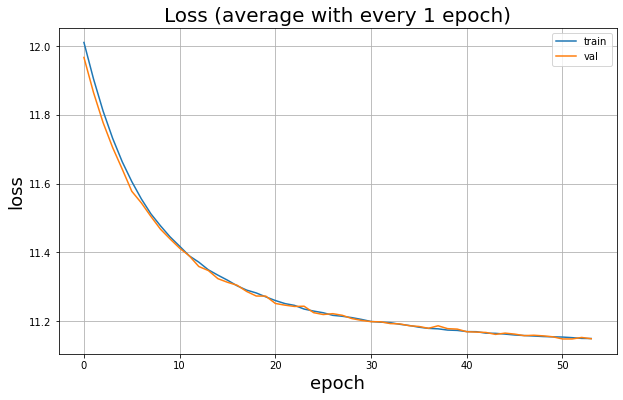

In [30]:
fig = plt.figure(figsize=(10,6))
acc = []
valAcc = []
step = 1
for i in range(len(history['loss'])//step):
  acc.append(np.mean(history['loss'][i:i+step:1]))
  valAcc.append(np.mean(history['val_loss'][i:i+step:1]))

plt.plot(acc)
plt.plot(valAcc)
plt.title('Loss (average with every {} epoch)'.format(step), fontsize=20)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.grid()
plt.legend(['train', 'val'], loc='upper right')

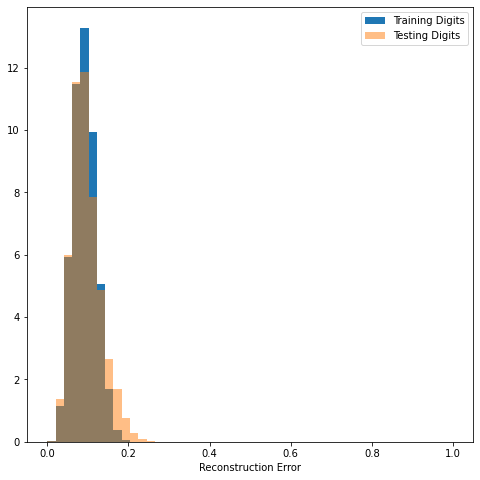

In [31]:
model_mse = lambda x: np.mean(np.square(x-vae.predict(x, batch_size = batch_size)), axis=1)
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.hist(model_mse(X_train), bins = np.linspace(0, 1, 50), label = 'Training Digits', density = True, alpha = 1.0)
ax1.hist(model_mse(y_train), bins = np.linspace(0, 1, 50), label = 'Testing Digits', density = True, alpha = 0.5)
# ax1.hist(model_mse(anomaly_data), bins = np.linspace(0, 1, 50), label = 'Anomaly Digits', density = True, alpha = 0.5)
ax1.legend()
ax1.set_xlabel('Reconstruction Error');

In [35]:
trainMean = np.mean(model_mse(X_train))
trainStd = np.std(model_mse(X_train))
testMean = np.mean(model_mse(y_train))
testStd = np.std(model_mse(y_train))
# anomalyMean = np.mean(model_mse(anomaly_data))
# anomalyStd = np.std(model_mse(anomaly_data))
print(trainMean,trainStd)
print(testMean,testStd)
# print(model_mse(X_train).shape)

0.09188269 0.028421585
0.09612759 0.03606436


In [ ]:
#0.09551288 0.04399634

#VAENoanchorMDSModel_200sample_7UAV_4uUAV1630381864924
# 0.09098803 0.029420968

